## 50. データの入手・整形

News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
抽出された事例をランダムに並び替える．
抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [2]:
import os 
cu_path = os.getcwd()
data_path = os.path.join(cu_path,"data","NewsAggregatorDataset","newsCorpora.csv")
data_write_path = os.path.join(cu_path,"data","full_data.txt")

publisher_list = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]


with open(data_path) as read_file,open(data_write_path,"w") as write_file:
    for line in read_file:
        line = line.split("\t")
        if line[3] in publisher_list:
            write_file.write(line[1]+"\t"+line[4]+"\n")



In [3]:
#shuflle
#!gshuf data/full_data.txt > data/full_data_shuf.txt

In [5]:
!wc -l data/full_data_shuf.txt
!head -n 10648 data/full_data_shuf.txt > data/train.txt
!sed -n 10649,11984p data/full_data_shuf.txt > data/dev.txt
!sed -n 11985,13356p data/full_data_shuf.txt > data/test.txt

   13356 data/full_data_shuf.txt


## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．


In [7]:
from gensim.models import KeyedVectors
path='data/GoogleNews-vectors-negative300.bin'
model=KeyedVectors.load_word2vec_format(path,binary=True)

In [9]:
import numpy as np
import csv

#word2vecの平均で作った文ベクトルを特徴量にする
#train.feature.txt => train_X,train_yのcsvファイルに分割
name_list = ["train","dev","test"]
label_list = ["b","t","e","m"]
cu_path = os.getcwd()
for name in name_list:
    read_path = os.path.join(cu_path,"data",name+".txt")
    write_path_X = os.path.join(cu_path,"data",name+"_X.csv")
    write_path_Y = os.path.join(cu_path,"data",name+"_y.csv")
    
    length = sum(1 for line in open(read_path))
    sent_vector = np.zeros((length,300))
    label_vector = np.zeros((length,1))


    with open(read_path) as read_file,open(write_path_X,"w") as write_file_X, open(write_path_Y,"w") as write_file_Y:
      
        for i,line in enumerate(read_file):
            sent,category=line.strip().split("\t")
#             print(sent)
#             print(sent_vector)

            #process for sentence
            sent = sent.replace("."," .").replace(","," ,")\
                       .replace("!"," !").replace(";"," ;").replace(":"," :")\
                       .replace('"','').replace("'","").replace("?"," ?").split()
        
            count = 0
            sent_vector_memory = 0
            for word in sent:
                if (word in model.vocab):
                    count +=1
                    sent_vector_memory +=  model[word]
                    
            sent_vector[i] = sent_vector_memory/count
            
            #process for label
            label_vector[i]=int(label_list.index(category)) 

        writer_X=csv.writer(write_file_X)
        writer_X.writerows(sent_vector)
        
        writer_Y=csv.writer(write_file_Y)
        writer_Y.writerows(label_vector)
            



## 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ

In [14]:
import warnings
from sklearn.linear_model import LogisticRegression


warnings.simplefilter('ignore')
train_X = np.loadtxt('data/train_X.csv',delimiter=",")
train_y = np.loadtxt('data/train_y.csv')

model = LogisticRegression()
results = model.fit(train_X,train_y)

print("Train set acc score =",results.score(train_X,train_y))

Train set acc score = 0.9174492862509391


## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [17]:
probs = model.predict_proba(train_x)
pred = model.predict(train_x)

print(probs, probs.shape)
print(pred)

[[3.61930590e-03 1.91934529e-03 9.93533518e-01 9.27830369e-04]
 [9.99135125e-01 3.14511819e-04 2.78677313e-04 2.71685932e-04]
 [9.90103832e-01 4.95141146e-03 3.31150674e-03 1.63325011e-03]
 ...
 [9.67639208e-01 3.16680085e-02 3.69995442e-04 3.22788319e-04]
 [1.10918537e-03 6.04106019e-03 9.92060141e-01 7.89613895e-04]
 [6.59020064e-03 8.83670377e-03 9.70546585e-01 1.40265109e-02]] (10648, 4)
[2. 0. 0. ... 0. 2. 2.]


## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [20]:
from sklearn.metrics import accuracy_score

test_X = np.loadtxt('data/test_X.csv',delimiter=",")
test_y = np.loadtxt('data/test_y.csv')

pred = model.predict(train_X)
print("train data acc:" ,accuracy_score(pred, train_y))

pred = model.predict(test_X)
print("test data acc:" ,accuracy_score(pred, test_y))

train data acc: 0.9174492862509391
test data acc: 0.8965014577259475


## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．



In [22]:
from sklearn.metrics import confusion_matrix

pred = model.predict(test_X)
c_matrix = confusion_matrix(pred, test_y)

print(c_matrix)

[[530  31  14   8]
 [ 19  96   7   5]
 [ 21  12 545  14]
 [  6   0   5  59]]


## 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [30]:
from sklearn.metrics import precision_score,recall_score,f1_score

pred = model.predict(test_X)

#None
print() 
print("precision", precision_score(pred, test_y, average = None))
print("recall", recall_score(pred, test_y, average = None))
print("f1", f1_score(pred, test_y, average = None))


#macro
print()
print("macro precision", precision_score(pred,test_y,average = "macro"))
print("macro  recall", recall_score(pred,test_y,average = "macro"))
print("macro f1", f1_score(pred,test_y,average = "macro"))

#micro
print()
print("micro precision", precision_score(pred, test_y, average = "micro"))
print("micro  recall", recall_score(pred, test_y, average = "micro"))
print("micro f1", f1_score(pred, test_y, average = "micro"))


precision [0.92013889 0.69064748 0.95446585 0.68604651]
recall [0.90909091 0.75590551 0.92060811 0.84285714]
f1 [0.91458154 0.72180451 0.9372313  0.75641026]

macro precision 0.8128246829795561
macro  recall 0.857115417966796
macro f1 0.8325069004653689

micro precision 0.8965014577259475
micro  recall 0.8965014577259475
micro f1 0.8965014577259475


## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ

In [38]:
#特徴量が非言語なので単語ベクトルのIDを出す
param = model.coef_
# print(param)
print(param.shape) #vocaburaly dimension weights
print("=============================")

decend_index = np.argsort(param)
print("top_feature_list\n",print(decend_index[-10:]))
print("worst_feature_list\n",print(decend_index[:10]))



(4, 300)
[[222 196 133 ... 155  42 213]
 [250 101 106 ...  21  80  28]
 [ 98 260  58 ... 204 207 133]
 [127  42 284 ...  23 237  59]]
top_feature_list
 None
[[222 196 133 ... 155  42 213]
 [250 101 106 ...  21  80  28]
 [ 98 260  58 ... 204 207 133]
 [127  42 284 ...  23 237  59]]
worst_feature_list
 None


# 58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [69]:
C_list = [10**(i-3) for i in range(10)]
C_list = np.array(C_list)
acc_list = np.zeros((3,len(C_list)))
#0:train 1:dev 2:test 

dev_X = np.loadtxt('data/dev_X.csv',delimiter=",")
dev_y = np.loadtxt('data/dev_y.csv')

for i,C_num in enumerate(C_list):
    model = LogisticRegression(C=C_num,random_state=0)
    model.fit(train_X,train_y)
    
    pred = model.predict(train_X)
    acc_list[0][i] = accuracy_score(pred,train_y)
    
    pred = model.predict(dev_X)
    acc_list[1][i] = accuracy_score(pred,dev_y)
    
    pred = model.predict(test_X)
    acc_list[2][i] = accuracy_score(pred,test_y)
    



(10,)


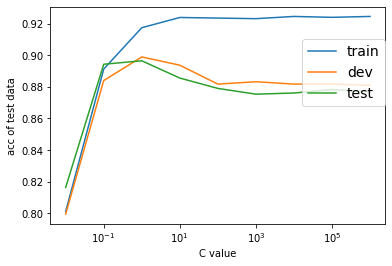

In [71]:
import matplotlib.pyplot as plt

#1~100までのCに対するaccの変化
print(acc_list[1].shape)
plt.plot(C_list[1:],acc_list[0][1:], label = "train")
plt.plot(C_list[1:],acc_list[1][1:], label = "dev")
plt.plot(C_list[1:],acc_list[2][1:], label = "test")
plt.legend(bbox_to_anchor=(1, 0.85), loc='upper right', borderaxespad=0, fontsize=14)
plt.xlabel("C value")
plt.ylabel("acc of test data")
plt.xscale('log')
plt.show()

## 59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [78]:
#data
train_X = np.loadtxt('data/train_X.csv',delimiter=",")
train_y = np.loadtxt('data/train_y.csv')
dev_X = np.loadtxt('data/dev_X.csv',delimiter=",")
dev_y = np.loadtxt('data/dev_y.csv')
test_X = np.loadtxt('data/test_X.csv',delimiter=",")
test_y = np.loadtxt('data/test_y.csv')

best acc on dev 0.8982035928143712
best C 1.0


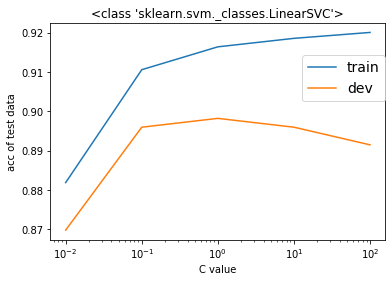

best acc on dev 0.8989520958083832
best C 1.0


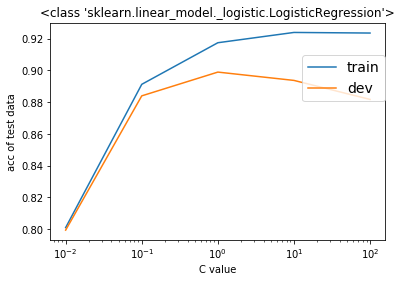

In [108]:
from sklearn.svm import LinearSVC

#SVC,LogisticRegression
models = [LinearSVC,LogisticRegression]
C_list = [10**(i-3) for i in range(6)]
C_list = np.array(C_list)

for model_name in models:
    acc_list = np.zeros((2,len(C_list)))
    for i,C_num in enumerate(C_list):
        model = model_name(C=C_num,random_state=0)
        model.fit(train_X,train_y)

        pred = model.predict(train_X)
        acc_list[0][i] = accuracy_score(pred,train_y)

        pred = model.predict(dev_X)
        acc_list[1][i] = accuracy_score(pred,dev_y)
    
    max_acc = np.max(acc_list[1])
    print("best acc on dev", max_acc)
    print("best C", C_list[np.argmax(acc_list[1])])

    plt.plot(C_list[1:],acc_list[0][1:], label = "train")
    plt.plot(C_list[1:],acc_list[1][1:], label = "dev")
    plt.title(str(model_name))
    plt.legend(bbox_to_anchor=(1, 0.85), loc='upper right', borderaxespad=0, fontsize=14)
    plt.xlabel("C value")
    plt.ylabel("acc of test data")
    plt.xscale('log')
    plt.show()


    


In [87]:
from sklearn.linear_model import Perceptron

model = Perceptron()
model.fit(train_X,train_y)
pred = model.predict(dev_X)

print(accuracy_score(pred,dev_y))

0.8592814371257484


In [105]:
from sklearn.naive_bayes import GaussianNB

model= GaussianNB()
model.fit(train_X,train_y)
pred = model.predict(dev_X)

print(accuracy_score(pred,dev_y))

0.8323353293413174


In [ ]:
#DecisionTreeClassifier
from sklearn.tree import  DecisionTreeClassifier


Depth_list = np.arange(5,21,1)
acc_list = np.zeros((2,len(Depth_list)))

for i,depth_value in enumerate(Depth_list):
    model = DecisionTreeClassifier(max_depth=depth_value,random_state=0,criterion='entropy')
    model.fit(train_X,train_y)

    pred = model.predict(train_X)
    acc_list[0][i] = accuracy_score(pred,train_y)

    pred = model.predict(dev_X)
    acc_list[1][i] = accuracy_score(pred,dev_y)
    

best acc on dev 0.7485029940119761
best depth 8


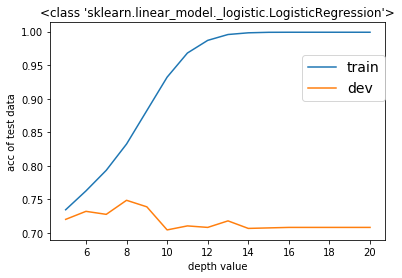

In [107]:
max_acc = np.max(acc_list[1])
print("best acc on dev", max_acc)
print("best depth", Depth_list[np.argmax(acc_list[1])])

plt.plot(Depth_list,acc_list[0], label = "train")
plt.plot(Depth_list,acc_list[1], label = "dev")
plt.title(str(model_name))
plt.legend(bbox_to_anchor=(1, 0.85), loc='upper right', borderaxespad=0, fontsize=14)
plt.xlabel("depth value")
plt.ylabel("acc of test data")
plt.show()

In [109]:
#test
model = LogisticRegression(C=1.0)
model.fit(train_X,train_y)
pred = model.predict(test_X)

print(accuracy_score(pred,test_y))

0.8965014577259475
